In [0]:
!pip install -q -U tensorflow>=1.8.0
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [0]:

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

print(x_train.shape)
print(x_test.shape)

In [0]:
input_img = Input(shape=(784,))
x = Dense(200, activation='tanh')(input_img)
x = Dropout(0.5)(x)
x = Dense(32, activation='tanh')(x)
encoded = Dropout(0.5)(x)
mean = encoded[:,:16]
var = tf.math.square(encoded[:,16:])
eps =  tf.random.normal([1,16], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)
mul = Multiply()([var,eps])
add = Add()([mul,mean])
y = Dense(200, activation='tanh')(add)
decoded = Dense(784, activation='sigmoid')(y)
auto_encoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(16,))
decoder_layer_1 = auto_encoder.layers[-2]
decoder_layer_2 = auto_encoder.layers[-1]
decoder = Model(encoded_input, decoder_layer_2(decoder_layer_1(encoded_input)))


In [0]:
auto_encoder.layers

In [0]:
def custom_loss_func(L,KL):
  bce = tf.keras.losses.BinaryCrossentropy()
  def custom_loss_fun(x,y):
    encoded = encoder(x)
    mean = encoded[:,:16]
    sd = tf.math.square(encoded[:,16:])
    loss = 0
    for i in range(L):
      ep = tf.random.normal([x.shape[0],16])
      z = mean + tf.multiply(ep,sd)
      decoded_output = decoder(z)
      decoder_loss = bce(x,decoded_output)
      loss += tf.reduce_mean(decoder_loss)
    loss = loss/L
    encoder_loss = KL * tf.reduce_sum(1.0 - tf.square(sd) - tf.square(mean) + tf.math.log(tf.square(sd)), 1)
    loss += tf.reduce_mean(encoder_loss)
    return loss
  return custom_loss_fun



In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks
%pwd

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
auto_encoder.compile(loss=custom_loss_func(1,0.00001), optimizer = optimizer)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='full_vae_weights.hdf5',save_weights_only=True, verbose = 0 )

In [0]:
auto_encoder.fit(x_train,x_train,batch_size=100,epochs=100,validation_data=(x_test, x_test),callbacks=[cp_callback])

(16, 784)


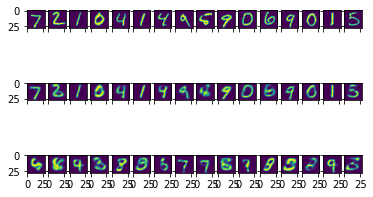

In [0]:
auto_encoder.load_weights(filepath='full_vae_weights.hdf5')
randoms = np.asarray([np.random.normal(0, 1, 16) for _ in range(16)])
images = decoder.predict(randoms)
print(images.shape)
imgs = auto_encoder.predict(x_test[:16])
imgs = [np.reshape(imgs[i],(28,28)) for i in range(len(imgs))]

fig, axs = plt.subplots(3,16, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

for i in range(len(imgs)) : 
  axs[0][i].imshow(x_test[i].reshape(28,28))
  axs[1][i].imshow(imgs[i])
  axs[2][i].imshow(images[i].reshape(28,28))

plt.show()
